In [1]:
import torch
import torch.nn.functional as F
import pyro
from pyro.distributions import *
from collections import Counter
import pyro.infer
import pyro.optim
pyro.enable_validation(True)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from IPython.display import Audio, display

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import utils
from importlib import reload

In [2]:
#reload(utils)

# Harmonic Clustering using a Dirichlet Process

The purpose of this model is to infer harmonic clusters from a dataset of chord examples, i.e. without using the harmonic labels per se.
In this initial version we still assume that the root is known and every chord example is expressed relative to its root.
A more realistic version of the model might include inference over the root too, which would allow the model to cluster chords such as II$^7$ and IV-*sixte-ajutée*.

The harmonic clusters are modeled using a dirichlet process, which allows the number of chord types to adapt to the data.
Each cluster is associated with a note distribution over chord tones and ornaments (similar to the "simple" model).
Generatively speaking, a new chord is sampled by first choosing one of the chord types and then sampling notes from the corresponding chord-tone and ornament distributions.
However, in addition to the simple model, each new chord can open a new chord type, in which case first the corresponding chord distributions for the new chord type are sampled, then the new chord is sampled from those.

The implementation of this model follows [the approach in the pyro docs](http://pyro.ai/examples/dirichlet_process_mixture.html).
We use the "stick-breaking" representation of the dirichlet process, which allows us to sample a set of independent, beta-distributed proportions $\beta$ so that the probability of choosing chord type $i$ is $\pi_i = \beta_i \prod_{j<i}(1-\beta_j)$.
Theoretically, this works for infinitely many categories, since the probability of any given category only depends on the "previous" categories.
In practice, however, the number of chord types is bounded by the number of chords in the dataset, and we may choose to consider an even smaller number of categories for efficiency reasons.

## Model and Guide

In [3]:
# set the range of pitch classes
utils.set_fifth_range(2*7) # two diatonics

In [4]:
def break_sticks(beta):
    """Takes a sequence (tensor) of betas and returns the corresponding categorical probabilities
    (along the right-most dimension)"""
    prods = (1-beta).cumprod(dim=-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(prods, (1, 0), value=1)

In [5]:
alpha = 2
p_observe=0.5

def chord_cluster_model(npcs, max_harmonies, data, subsamples=500):    
    # betas for the stick-breaking process
    with pyro.plate("betas", max_harmonies-1):
        beta = pyro.sample("beta", Beta(1, alpha))
    # parameters for the chord type categorical
    p_harmony = break_sticks(beta)
#     p_harmony = pyro.sample('p_harmony', Dirichlet(0.5 * torch.ones(max_harmonies)))
    
    # distribution of ornament probability
    p_is_chordtone = pyro.sample('p_is_chordtone', Beta(1, 1))
    
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', max_harmonies):
        # distribution of notes per note type
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(0.5 * torch.ones(npcs)))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(0.5 * torch.ones(npcs)))        
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        p_ct = p_is_chordtone       * p_chordtones
        p_or = (1 - p_is_chordtone) * p_ornaments
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([p_observe * p_ct, p_observe * p_or, (1-p_observe) * p_unobserved], dim=1)
    
    # sampling the data:
    nchords = data.shape[0]
    with pyro.plate("chords", nchords) as ind:
        # pick a harmony
        h = pyro.sample('h', Categorical(p_harmony))
        # sample chordtones
        chordtones = pyro.sample('chord', Multinomial(1, p_tones[h], validate_args=False), obs=data[ind])
        # summarize the results
        chords = {'h': h, 'counts': chordtones.reshape(-1,npcs)}
    return chords

In [6]:
@pyro.infer.config_enumerate
def chord_cluster_guide(npcs, max_harmonies, data, subsamples=500):
    nchords = data.shape[0]
    
    # posterior of betas
    params_betas = pyro.param('params_betas', torch.ones(max_harmonies-1),
                              constraint=constraints.positive)
    with pyro.plate("betas", max_harmonies-1):
        pyro.sample("beta", Beta(torch.ones(max_harmonies-1), params_betas))

#     params_p_harmony = pyro.param('params_p_harmony', 0.5 * torch.ones(max_harmonies),
#                                   constraint=constraints.positive)
#     pyro.sample('p_harmony', Dirichlet(params_p_harmony))
    
    # posterior of ornament probability
    alpha_p_ict = pyro.param('alpha_p_ict', torch.tensor(1.), constraint=constraints.positive)
    beta_p_ict = pyro.param('beta_p_ict', torch.tensor(1.), constraint=constraints.positive)
    pyro.sample('p_is_chordtone', Beta(alpha_p_ict, beta_p_ict))
    
    # posteriors of notes dists in harmonies
    # initialize the parameters randomly in order to avoid collapsing clusters
    params_p_ct_init = lambda: Gamma(5,0.5).sample([max_harmonies, npcs])
    params_p_or_init = lambda: Gamma(5,0.5).sample([max_harmonies, npcs])
    params_p_chordtones = pyro.param('params_p_chordtones', params_p_ct_init,
                                     constraint=constraints.greater_than(0.0001))
    params_p_ornaments = pyro.param('params_p_ornaments', params_p_or_init,
                                    constraint=constraints.greater_than(0.0001))
    with pyro.plate('harmonies', max_harmonies) as ind:
        pyro.sample('p_chordtones', Dirichlet(params_p_chordtones))
        pyro.sample('p_ornaments', Dirichlet(params_p_ornaments))
        
    # posteriors of each chord's chord type
    nchords = data.shape[0]
    params_h = pyro.param('params_h', torch.ones(nchords, max_harmonies) / max_harmonies,
                          constraint=constraints.simplex)
    #nnotes = obs_chord.sum().int()
    with pyro.plate("chords", nchords, subsample_size=min(nchords,subsamples)) as ind:
        h = pyro.sample('h', Categorical(params_h[ind]))

## Data Loading

In [7]:
# load wikifonia data
wiki_harms = utils.load_csv('data/harmonies.csv')
wiki_harms

,chordid,label,fifth,type
0,0,dominant-13th,3,chordtone
1,1,major-sixth,1,unknown
2,1,major-sixth,1,unknown
3,1,major-sixth,4,chordtone
4,1,major-sixth,3,unknown
...,...,...,...,...
898967,279831,major,0,chordtone
898968,279832,minor,-3,unknown
898969,279832,minor,1,unknown
898970,279832,minor,1,unknown


In [8]:
wiki_data = torch.cat([utils.chord_tensor(grp.fifth, grp.type) for _, grp in wiki_harms.groupby('chordid')], dim=0)
wiki_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

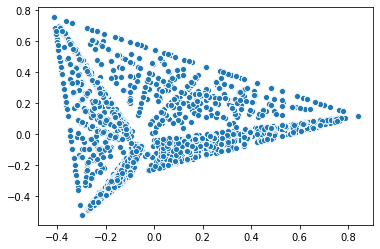

In [9]:
wiki_pca = PCA(n_components=2)
wiki_data_norm = normalize(wiki_data[:, 0:2*utils.get_npcs()], axis=1, norm='l1')
# sums = wiki_data_norm.sum(axis=1, keepdims=True)
# valid = sums[:,0] != 0.
# wiki_data_norm = wiki_data_norm[valid] / sums[valid]
wiki_pca.fit(wiki_data_norm)
wiki_reduced = wiki_pca.transform(wiki_data_norm)
sns.scatterplot(wiki_reduced[:, 0], wiki_reduced[:, 1])

In [10]:
wiki_data_norm.shape

(252875, 58)

In [11]:
wiki_nharmonies = wiki_harms['label'].nunique()
wiki_nharmonies

48

## Inference

In [12]:
def plot_summary(losses):
    params_ct = pyro.get_param_store().get_param('params_p_chordtones').detach()
    params_or = pyro.get_param_store().get_param('params_p_ornaments').detach()
    params = torch.cat((params_ct, params_or), dim=1)
    params_norm = normalize(params)
    cluster_coords = wiki_pca.transform(params_norm)
    
    assignment = pyro.get_param_store().get_param('params_h').detach().argmax(dim=1)
    cats = np.array(["cat_{}".format(i) for i in range(params.shape[0])])
    labels = cats[assignment]
    
    post_betas = pyro.get_param_store().get_param("params_betas").detach()
    post_betas_exp = 1 / (1 + post_betas)
    cluster_weights = break_sticks(post_betas_exp)
    
    fig, ax = plt.subplots(1,3, figsize=(17,4))
    sns.scatterplot(wiki_reduced[:,0], wiki_reduced[:,1], ax=ax[0], color='gray')
    p1 = sns.scatterplot(cluster_coords[:,0], cluster_coords[:,1], hue=cats, size=cluster_weights,
                         ax=ax[0], legend=False)
    sns.scatterplot(wiki_reduced[:,0], wiki_reduced[:,1], hue=labels, hue_order=cats, ax=ax[1], legend=False)
    
    ax[2].plot(losses)
    ax[2].set_xlabel("step")
    ax[2].set_ylabel("loss")
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

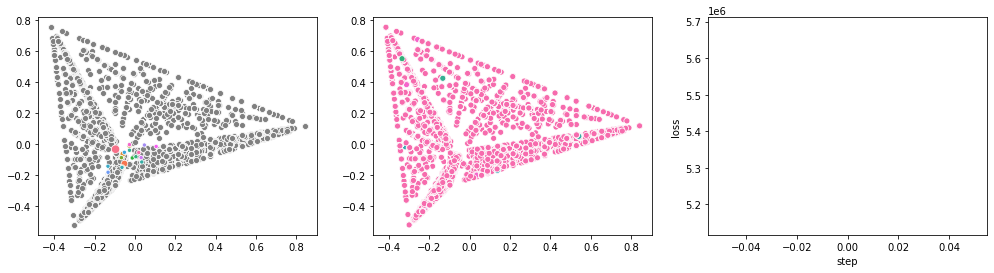

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [14]:
# optimize the parameters of the guide
pyro.clear_param_store()
svi = pyro.infer.SVI(model=chord_cluster_model,
                     guide=chord_cluster_guide,
                     optim=pyro.optim.Adam({"lr": 0.005, "betas": (0.95, 0.999)}),
                     loss=pyro.infer.TraceEnum_ELBO(max_plate_nesting=1))

# configuration values
nsteps = 10 # max 1500
subsamples = 5_000 # 10_000 is pretty fast (~15 it/s), but lower values are fine wrt. variance
max_harms = 20

# set up collection of intermediate values for the loss and some of the parameters
losses = np.zeros(nsteps)
param_values = {name:np.zeros(nsteps) for name in ['alpha_p_ict', 'beta_p_ict']}

# run the optimization
for i in tqdm.trange(nsteps):
    losses[i] = svi.step(utils.get_npcs(), max_harms, wiki_data, subsamples)
    ps = pyro.get_param_store()
    for (name, value) in ps.items():
        if name in param_values:
            param_values[name][i] = value.item()
    if i % 100 == 0:
        plot_summary(losses[0:i+1])

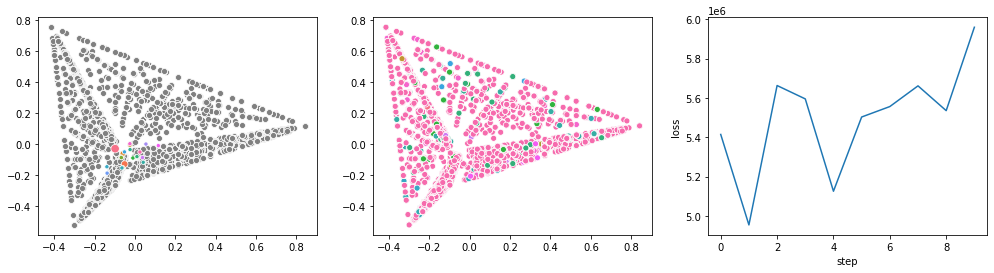

In [15]:
plot_summary(losses)

<BarContainer object of 20 artists>

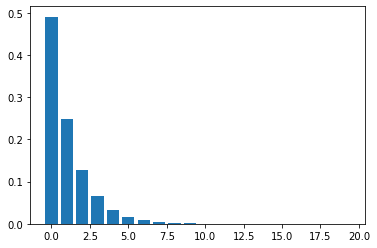

In [16]:
post_betas = pyro.get_param_store().get_param("params_betas").detach()
post_betas_exp = 1 / (1 + post_betas)
post_harmonies_exp = break_sticks(post_betas_exp)
plt.bar(range(max_harms), post_harmonies_exp)

In [17]:
post_chordtones = pyro.get_param_store().get_param("params_p_chordtones").detach()
post_ornaments  = pyro.get_param_store().get_param("params_p_ornaments").detach()

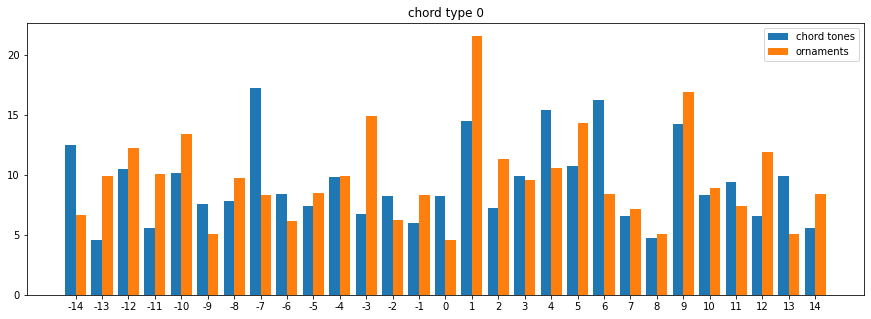

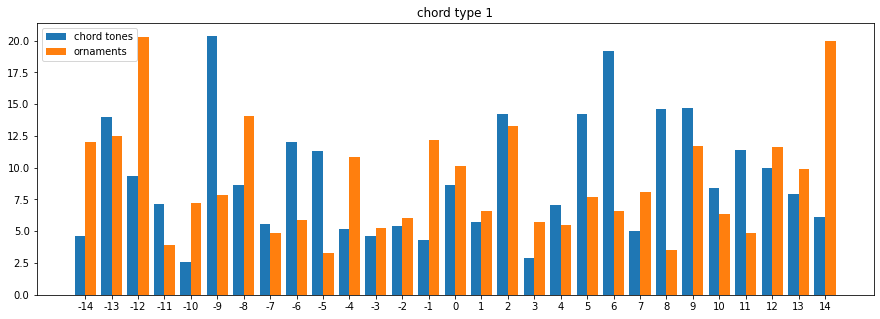

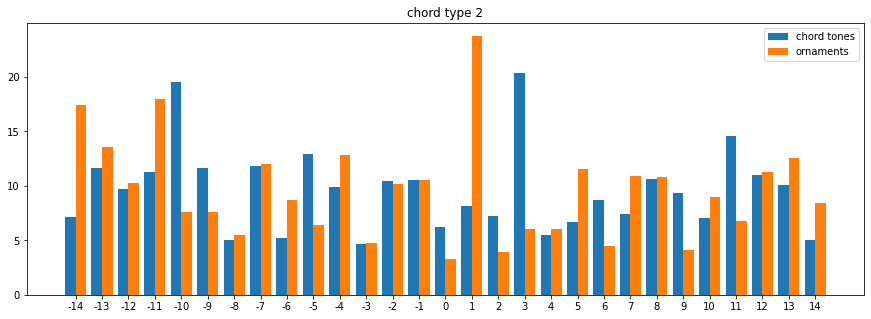

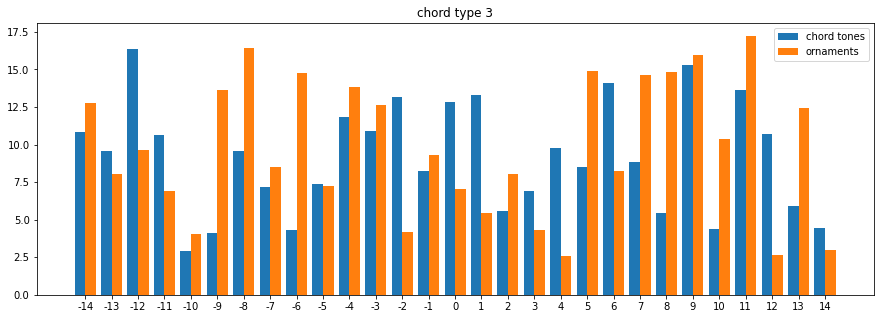

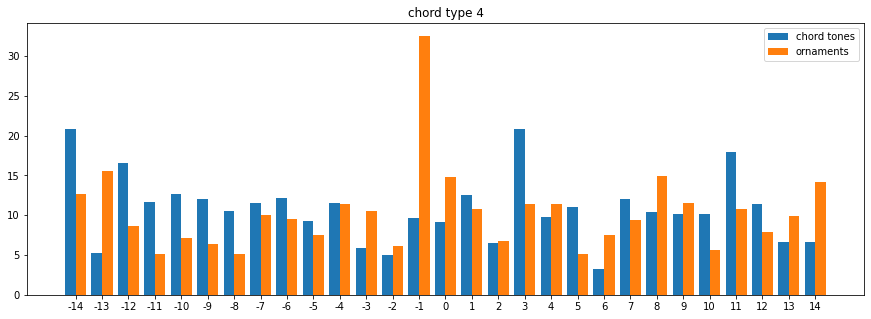

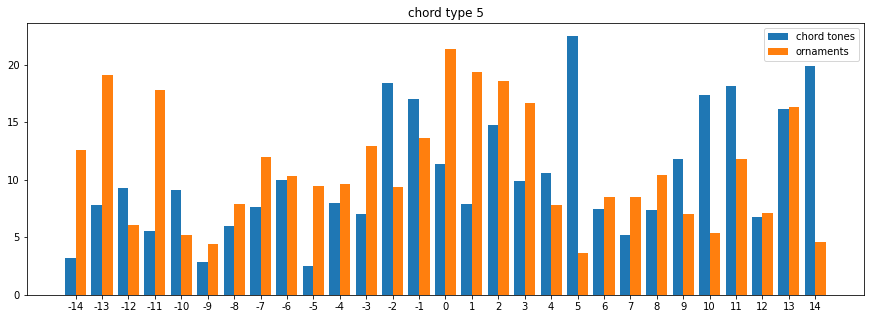

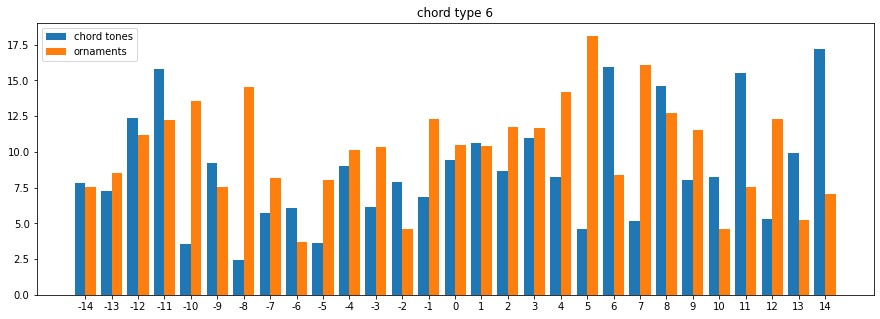

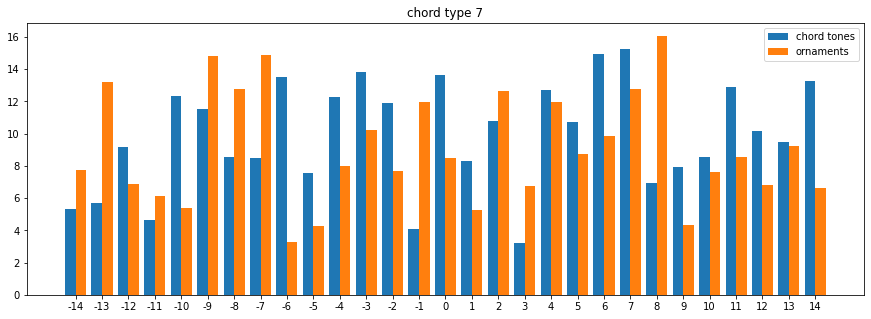

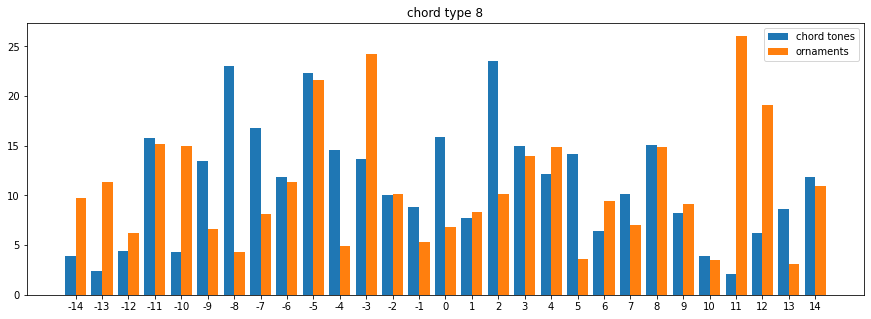

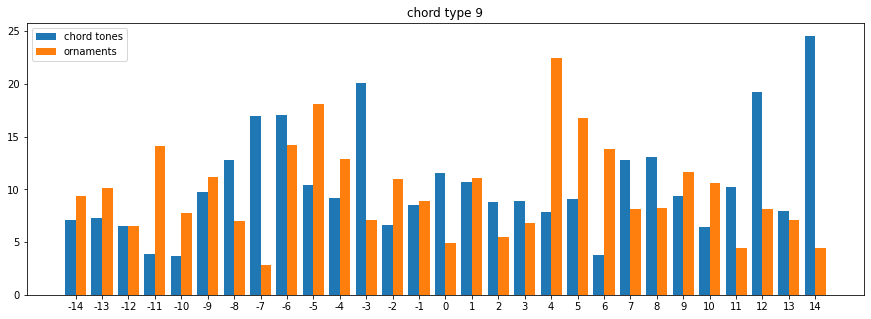

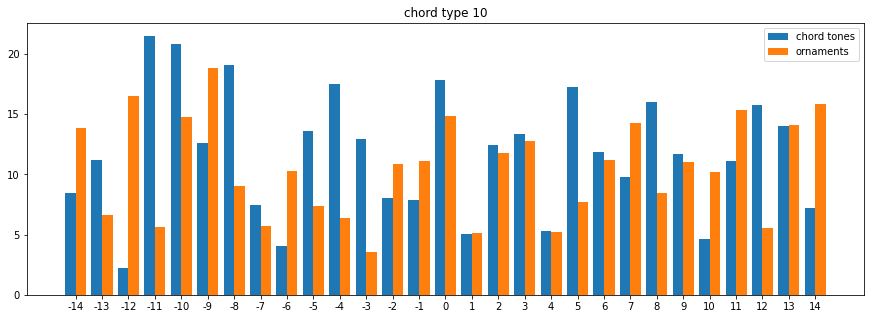

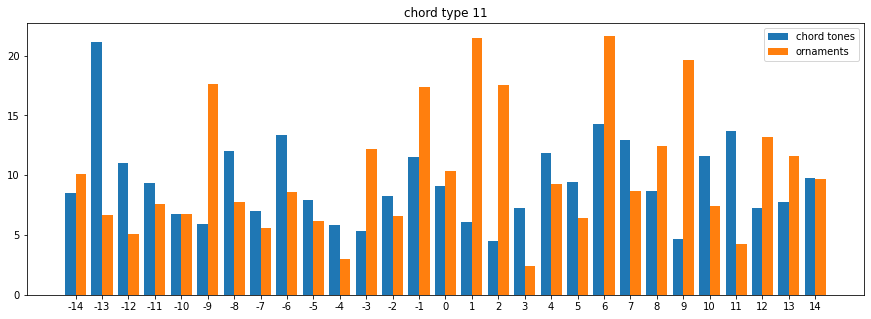

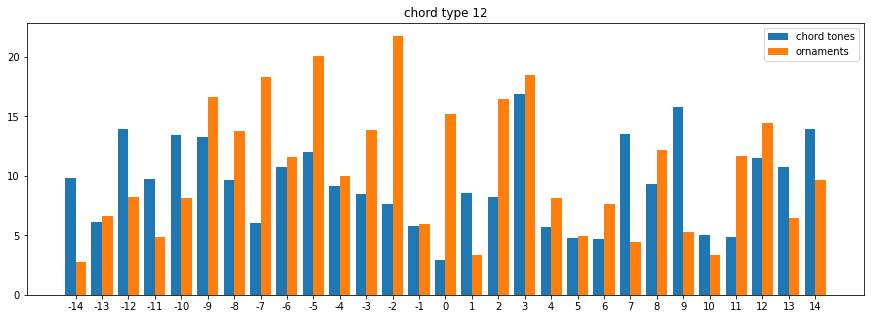

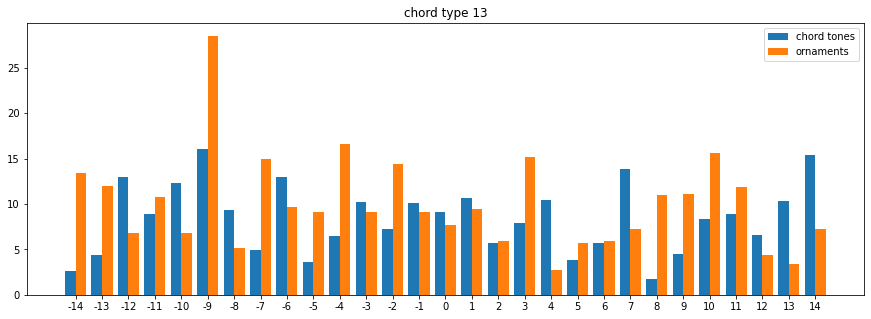

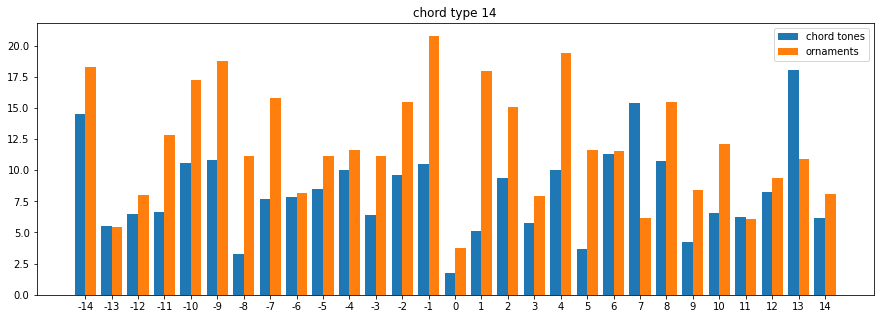

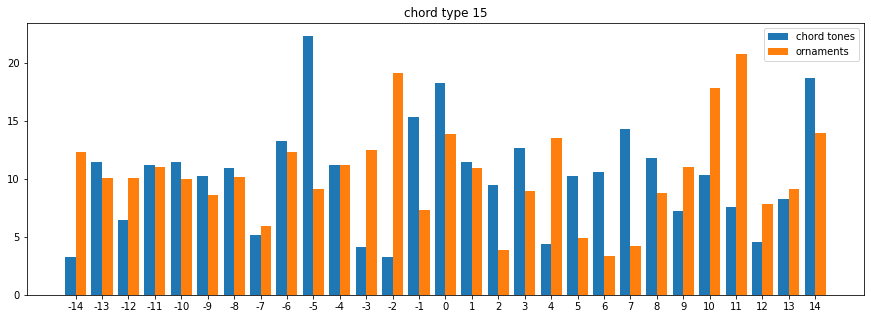

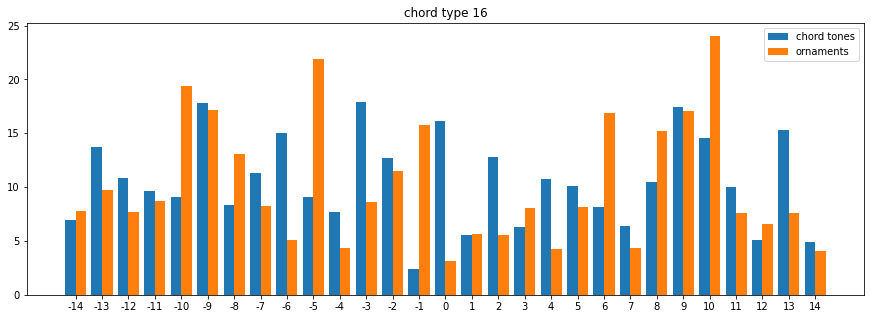

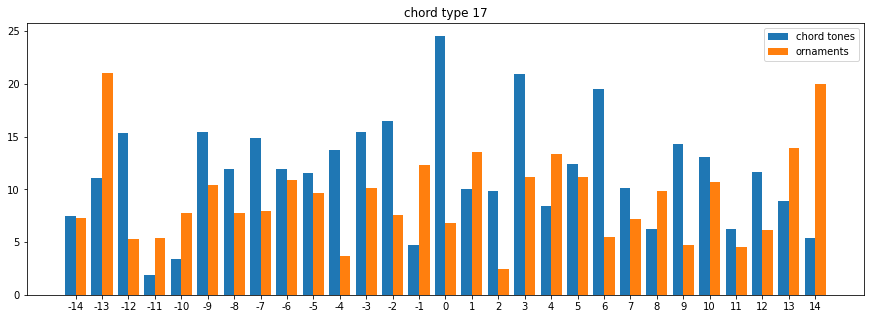

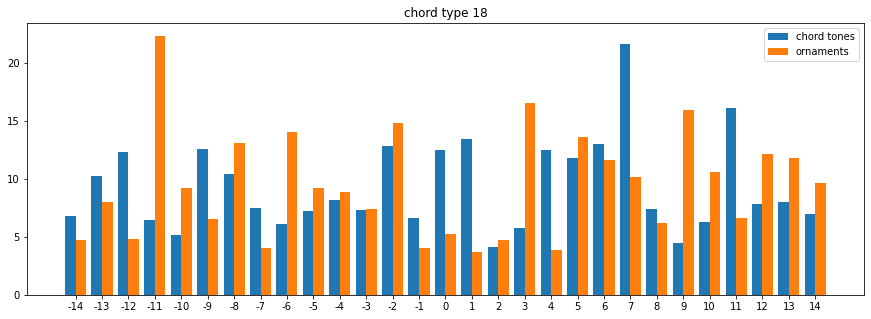

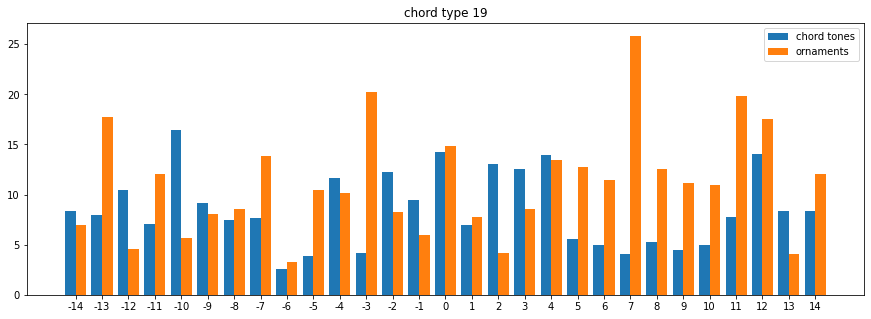

In [18]:
for i in range(max_harms):
    utils.plot_profile(post_chordtones[i], post_ornaments[i], "chord type {}".format(i))
    utils.play_chord(post_chordtones[i])

In [19]:
post_chordtones

tensor([[12.5317,  4.5550, 10.5058,  5.5369, 10.1708,  7.5335,  7.8402, 17.2337,
          8.3955,  7.3751,  9.8547,  6.7826,  8.2100,  6.0285,  8.2317, 14.5058,
          7.2800,  9.9140, 15.3774, 10.7087, 16.2273,  6.6068,  4.7000, 14.2756,
          8.3145,  9.3928,  6.5930,  9.8695,  5.5613],
        [ 4.5916, 13.9769,  9.3197,  7.1134,  2.5828, 20.3704,  8.6174,  5.6076,
         12.0090, 11.3004,  5.1479,  4.6199,  5.4179,  4.3131,  8.6470,  5.7668,
         14.2257,  2.9118,  7.0600, 14.1955, 19.2065,  5.0274, 14.6582, 14.7392,
          8.4257, 11.4134, 10.0165,  7.9671,  6.0915],
        [ 7.1751, 11.6297,  9.7070, 11.2344, 19.5191, 11.6257,  5.0587, 11.8610,
          5.1998, 12.8865,  9.8937,  4.6748, 10.4211, 10.4900,  6.2420,  8.1325,
          7.1959, 20.3737,  5.5002,  6.6685,  8.6764,  7.4072, 10.6083,  9.3783,
          7.0883, 14.5835, 10.9824, 10.0734,  5.0270],
        [10.8411,  9.5498, 16.3485, 10.6093,  2.9103,  4.1236,  9.5830,  7.1465,
          4.3227,  7.3650